# Automatic Differentiation and Neural Networks with PyTorch

Welcome to this notebook! We will explore the foundations of Deep Learning using PyTorch. This class is designed to bridge the gap between mathematical theory and code implementation.

**Agenda:**
1.  **Automatic Differentiation (Autograd):** Understanding how PyTorch calculates gradients.
2.  **The Computational Graph:** Visualizing how operations are connected.
3.  **Neural Network from Scratch:** Implementing a model using only basic tensors and autograd.
4.  **PyTorch Modules (`torch.nn`):** Building models standard PyTorch tools.
5.  **Function Approximation:** Fitting a non-linear function (Analytical function).

In [17]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from torch import (
    linspace,
    manual_seed,
    nn,
    no_grad,
    optim,
    pi,
    rand,
    randn,
    randn_like,
    sin,
    tensor,
)
from torch.autograd import grad
from torchviz import make_dot

manual_seed(42)

## 1. Automatic Differentiation (Autograd)

PyTorch's core strength is **Autograd**.
It automatically computes gradients for tensors, which is essential for backpropagation in neural networks.

To track computations on a tensor, we set `requires_grad=True`.

![](https://upload.wikimedia.org/wikipedia/commons/7/71/Sine_cosine_one_period.svg)

In [18]:
x = tensor(data=pi, requires_grad=True)
sin(input=x).backward()
print(f"cos(π): {x.grad}")

cos(π): -1.0


## 2. The Computational Graph

PyTorch builds a **Dynamic Computational Graph** (DAG) as you perform operations. 
- **Leaves**: Input tensors (like `x` above).
- **Nodes**: Functions/Operations (Add, Mul, Pow).

We can inspect this graph via the `grad_fn` attribute of the resulting tensors.

In [19]:
def print_graph(grad_fn, depth=0):
    indent = "  " * depth
    print(f"{indent}{grad_fn}")
    if hasattr(grad_fn, "next_functions"):
        for next_fn, _ in grad_fn.next_functions:
            if next_fn is not None:
                print_graph(next_fn, depth + 1)

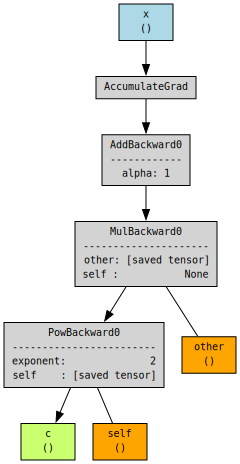

In [20]:
x = tensor(data=2.0, requires_grad=True)
a = x + 1
b = a * 2
c = b**2

make_dot(var=c, params={"x": x, "c": c}, show_attrs=True, show_saved=True)

In [21]:
print(f"c: {c}")
print(f"c.grad_fn: {c.grad_fn} (Power operation)")
print(
    f"c.grad_fn.next_functions: {c.grad_fn.next_functions} (Points to Multiplication)"
)
print(
    f"c.grad_fn...next_functions: {c.grad_fn.next_functions[0][0].next_functions} (Points to Addition)"
)

# This chain represents: Power -> Multiplication -> Addition -> AccumulateGrad (Leaf)
print("\n--- Visualizing the Graph ---")
print_graph(c.grad_fn)

c: 36.0
c.grad_fn: <PowBackward0 object at 0x7bbd94d12d70> (Power operation)
c.grad_fn.next_functions: ((<MulBackward0 object at 0x7bbd941c1930>, 0),) (Points to Multiplication)
c.grad_fn...next_functions: ((<AddBackward0 object at 0x7bbd941c1060>, 0), (None, 0)) (Points to Addition)

--- Visualizing the Graph ---


In [22]:
x = tensor(data=1, dtype=float, requires_grad=True)
y = tensor(data=2, dtype=float, requires_grad=True)
z = x * y + y**2
dzdx = grad(outputs=z, inputs=x, retain_graph=True)[0]
dzdy = grad(outputs=z, inputs=y)[0]
print(dzdx, dzdy)  # ∂z/∂x=y, ∂z/∂y=x+2y

tensor(2., dtype=torch.float64) tensor(5., dtype=torch.float64)


## 3. Approximating analytical function
Before using the high-level API, let's build a simple **Linear Regression** model ($y = wx + b$) using raw tensors.

**Goal:** Learn the function $y = 3x + 2$.

In [23]:
# 1. Data Generation
X = rand(size=(100, 1)) * 10  # Random values [0, 10]
y_true = 3 * X + 2 + randn_like(input=X) * 0.5  # Add some noise

# 2. Initialize Parameters (Weights & Bias)
w = randn(size=(1,), requires_grad=True)
b = randn(size=(1,), requires_grad=True)

lr = 0.01
epochs = 1000
losses = []

# 3. Training Loop
for epoch in range(epochs):
    # Forward pass
    y_pred = w * X + b

    # Loss calculation (Mean Squared Error)
    loss = ((y_pred - y_true) ** 2).mean()
    losses.append(loss.item())

    # Backward pass (compute gradients)
    loss.backward()

    # Update weights (Gradient Descent)
    # We use torch.no_grad() because these updates shouldn't be part of the computational graph
    with no_grad():
        w -= lr * w.grad
        b -= lr * b.grad

        # Reset gradients for the next iteration!
        w.grad.zero_()
        b.grad.zero_()

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch}: Loss = {loss.item():.4f}, w = {w.item():.2f}, b = {b.item():.2f}"
        )

print("\nTarget: w=3, b=2")
print(f"Learned: w={w.item():.2f}, b={b.item():.2f}")

Epoch 0: Loss = 770.5294, w = 2.00, b = -0.20
Epoch 100: Loss = 0.5915, w = 3.17, b = 0.80
Epoch 200: Loss = 0.3292, w = 3.10, b = 1.30
Epoch 300: Loss = 0.2285, w = 3.05, b = 1.61
Epoch 400: Loss = 0.1899, w = 3.02, b = 1.80
Epoch 500: Loss = 0.1750, w = 3.01, b = 1.92
Epoch 600: Loss = 0.1693, w = 2.99, b = 2.00
Epoch 700: Loss = 0.1672, w = 2.99, b = 2.04
Epoch 800: Loss = 0.1663, w = 2.98, b = 2.07
Epoch 900: Loss = 0.1660, w = 2.98, b = 2.09

Target: w=3, b=2
Learned: w=2.98, b=2.10


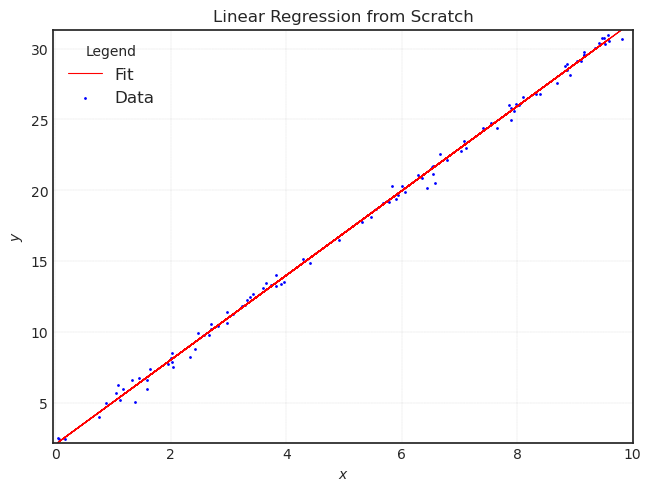

In [ ]:
Y = (w * X + b).detach().numpy()

fig: Figure
ax: Axes
with plt.style.context("seaborn-v0_8-white"):
    fig, ax = plt.subplots(layout="constrained")
    ax.plot(
        X,
        Y,
        color="red",
        label="Fit",
        linestyle="solid",
        linewidth=0.8,
    )
    ax.scatter(x=X, y=y_true, s=1, c="blue", label="Data")
    ax.grid(c="gray", linewidth=0.1, linestyle="dashed")
    ax.set_xlim(left=X.min() - 8e-2, right=X.max() + 2e-1)
    ax.set_ylim(bottom=Y.min(), top=Y.max())
    ax.set_xlabel(xlabel=r"$x$")
    ax.set_ylabel(ylabel=r"$y$")
    ax.legend(loc="best", title="Legend", shadow=True, fontsize=12)
    ax.set_title(
        label="Linear Regression from Scratch",
        loc="center",
        wrap=True,
    )

## Non-linear approx

In [ ]:
x = linspace(start=-pi, end=pi, steps=2000)
y = sin(x)

a = randn(1, requires_grad=True)
b = randn(1, requires_grad=True)
c = randn(1, requires_grad=True)
d = randn(1, requires_grad=True)

In [26]:
for t in range(5000):
    y_pred = a + b * x + c * x**2 + d * x**3
    loss = (y_pred - y).pow(2).sum()
    loss.backward()
    with no_grad():
        a.data -= 1e-6 * a.grad
        b.data -= 1e-6 * b.grad
        c.data -= 1e-6 * c.grad
        d.data -= 1e-6 * d.grad

        a.grad.zero_()
        b.grad.zero_()
        c.grad.zero_()
        d.grad.zero_()
        # print(loss.item())

In [ ]:
pred = (a + b * x + c * x**2 + d * x**3).detach().numpy()

with plt.style.context("seaborn-v0_8-white"):
    fig, ax = plt.subplots(layout="constrained")
    ax.plot(
        x,
        y,
        color="red",
        label="Actual",
        linestyle="solid",
        linewidth=0.8,
    )
    ax.scatter(x=x, y=pred, s=0.01, c="blue", label="Predicted")
    ax.grid(c="gray", linewidth=0.1, linestyle="dashed")
    ax.set_xlim(left=x.min(), right=x.max())
    ax.set_ylim(bottom=-1, top=1)
    ax.set_xlabel(xlabel=r"$x$")
    ax.set_ylabel(ylabel=r"$y$")
    ax.legend(loc="best", title="Legend", shadow=True, fontsize=12)
    ax.set_title(
        label="Non-linear approximation",
        loc="center",
        wrap=True,
    )

## 4. Using `torch.nn`

Now, let's do the same thing using PyTorch's `nn` module. This simplifies managing parameters and layers.

In [28]:
# 1. Generate Non-Linear Data
X_quad = linspace(-5, 5, 200).view(-1, 1)
y_quad = X_quad**2 + randn_like(input=X_quad) * 1.0  # Add noise


# 2. Define a Multilayer Perceptron (MLP)
# We need hidden layers and non-linear activation functions (ReLU, Tanh, etc.)
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),  # Hidden layer 1
            nn.ReLU(),  # Activation
            nn.Linear(20, 20),  # Hidden layer 2
            nn.ReLU(),  # Activation
            nn.Linear(20, 1),  # Output layer
        )

    def forward(self, x):
        return self.net(x)


model_quad = SimpleMLP()

# 3. Training Config
# Adam is usually faster/better than SGD for MLPs
optimizer = optim.Adam(model_quad.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 4. Training Loop
epochs = 1500
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model_quad(X_quad)
    loss = criterion(y_pred, y_quad)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# 5. Visualize Results
model_quad.eval()  # Set to evaluation mode
with no_grad():
    y_pred_final = model_quad(X_quad)

Epoch 0: Loss = 127.1782
Epoch 200: Loss = 1.1579
Epoch 400: Loss = 0.8221
Epoch 600: Loss = 0.8106
Epoch 800: Loss = 0.8056
Epoch 1000: Loss = 0.8017
Epoch 1200: Loss = 0.7967
Epoch 1400: Loss = 0.7942


In [ ]:
with plt.style.context("seaborn-v0_8-white"):
    fig, ax = plt.subplots(layout="constrained")
    ax.plot(
        X_quad,
        y_pred_final,
        color="red",
        label="NN Prediction",
        linestyle="solid",
        linewidth=0.8,
    )
    ax.scatter(x=X_quad, y=y_quad, s=1, c="blue", label="Noisy Data", alpha=0.5)
    ax.grid(c="gray", linewidth=0.1, linestyle="dashed")
    ax.set_xlim(left=X_quad.min(), right=X_quad.max())
    ax.set_ylim(bottom=y_pred_final.min() - 1e-1, top=y_pred_final.max() + 3e-1)
    ax.set_xlabel(xlabel=r"$x$")
    ax.set_ylabel(ylabel=r"$y$")
    ax.legend(loc="best", title="Legend", shadow=True, fontsize=12)
    ax.set_title(
        label="Approximating Quadratic Function with MLP",
        loc="center",
        wrap=True,
    )

## 6. Suggestions for Experimentation

Try these modifications to deepen your understanding:

1.  **Activations:** In the MLP, change `nn.ReLU()` to `nn.Sigmoid()` or `nn.Tanh()`. Does the network learn faster or slower? How does the fit line look?
2.  **Width vs Depth:** Try removing one hidden layer but increasing the neuron count (e.g., `nn.Linear(1, 50)` -> `nn.ReLU()` -> `nn.Linear(50, 1)`). Does it work as well as the deep version?
3.  **Learning Rate:** Change `lr` to `0.1` or `0.0001`. What happens to the loss curve?
4.  **Target Function:** Try fitting a periodic function like `y = sin(x)`. You might find that standard ReLU networks struggle with periodicity outside the training range (extrapolation).